## CAN-bus-for-anamolies-detection

In [ ]:
!pip install seaborn

In [ ]:
!sudo apt upgrade python3

In [10]:
!python3 --version


Python 3.10.12


In [ ]:
!pip install joblib


In [13]:
import joblib


In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
tf.random.set_seed
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [20]:
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

## Data loading and preprocessing

In [21]:
CSV_FILE = "/content/10_second_master_and_slave.csv"
preprocessed_data = pd.DataFrame()

In [22]:
df = pd.read_csv(CSV_FILE)

In [23]:
df.head()

,timestamp,event_type,priority,function,subfunction,node_id,len,d0,d1,d2,d3,d4,d5,d6,d7,Unnamed: 15
0,1584317951333201,MSG_RX,0x00,0xf0,0xf1,0x34,2,0x00,0x00,0x00,0x00,0x00,0x00,0x00,0x00,NaN
1,1584317951333212,MSG_RX,0x01,0xf4,0xd0,0x10,6,0xFE,0xDE,0xBE,0xBE,0xCA,0xFE,0x00,0x00,NaN
2,1584317951383198,MSG_RX,0x00,0xf0,0xf1,0x34,2,0x00,0x01,0x00,0x00,0x00,0x00,0x00,0x00,NaN
3,1584317951383210,MSG_RX,0x01,0xf4,0xd0,0x10,6,0xFE,0xDE,0xBE,0xBE,0xCA,0xFE,0x00,0x00,NaN
4,1584317951433198,MSG_RX,0x00,0xf0,0xf1,0x34,2,0x00,0x02,0x00,0x00,0x00,0x00,0x00,0x00,NaN


In [24]:
# Selección de columnas de interés
preprocessed_data = df[
    [
        'priority','function','subfunction','node_id', # CANID
        'len', # Length del payload
        'd0','d1','d2','d3','d4','d5','d6','d7' # Payload
    ]
]
preprocessed_data = preprocessed_data.apply(lambda x: x.astype(str).map(lambda x: float(int(x, base=16))))
preprocessed_data

,priority,function,subfunction,node_id,len,d0,d1,d2,d3,d4,d5,d6,d7
0,0.0,240.0,241.0,52.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,244.0,208.0,16.0,6.0,254.0,222.0,190.0,190.0,202.0,254.0,0.0,0.0
2,0.0,240.0,241.0,52.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,244.0,208.0,16.0,6.0,254.0,222.0,190.0,190.0,202.0,254.0,0.0,0.0
4,0.0,240.0,241.0,52.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,1.0,244.0,208.0,16.0,6.0,254.0,222.0,190.0,190.0,202.0,254.0,0.0,0.0
398,0.0,240.0,241.0,52.0,2.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0
399,1.0,244.0,208.0,16.0,6.0,254.0,222.0,190.0,190.0,202.0,254.0,0.0,0.0
400,0.0,240.0,241.0,52.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Scaling

- Acá hay un púnto importante, no se debe usar MinMax porque los campos de los CANID son valores enumerados.
- Debería pasar por otra etapa de transformación antes.

In [25]:
from sklearn import preprocessing

x = preprocessed_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
preprocessed_data = pd.DataFrame(x_scaled)
preprocessed_data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.004505,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.009009,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,1.0,1.0,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,0.0,0.0
398,0.0,0.0,1.0,1.0,0.0,0.0,0.085586,0.0,0.0,0.0,0.0,0.0,0.0
399,1.0,1.0,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,0.0,0.0
400,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Autoencoder Model

In [26]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

## Training

Data is organized in a matrix of N_SAMPLES rows and 13 feature columns.

In [27]:
train = preprocessed_data
print("Train: ", train.shape)
test = preprocessed_data
print("Test: ", test.shape)

Train:  (402, 13)
Test:  (402, 13)


Required format for LSTM input is (N_SAMPLES,N_TIMESTEPS,N_FEATURES)
- TODO: HP tuning de N_TIMESTEPS

In [28]:
X_train = train.values
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Train: ", X_train.shape)

X_test = test.values
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test: ", X_test.shape)

Train:  (402, 1, 13)
Test:  (402, 1, 13)


In [29]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 13)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 16)               │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4)                   │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 4)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 4)                │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 1, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 13)               │             221 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,965 (15.49 KB)

 Trainable params: 3,965 (15.49 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
nb_epochs = 100
batch_size = 10
history = model.fit( X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.4322 - val_loss: 0.4355
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4375 - val_loss: 0.4329
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4330 - val_loss: 0.4029
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3183 - val_loss: 0.1510
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1290 - val_loss: 0.0774
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0723 - val_loss: 0.0676
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0691 - val_loss: 0.0654
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0676 - val_loss: 0.0645
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0702 - val_loss: 0.0640
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0684 - val_loss: 0.0604
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0602 - val_loss: 0.0574
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [31]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred.shape

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


(402, 13)

In [32]:
X_pred[0]

array([ 2.0352285e-04,  2.8932933e-04,  9.9988019e-01,  1.0005471e+00,
       -1.3530534e-04,  2.8378563e-04,  4.0606152e-02, -5.7713198e-04,
       -3.9831363e-04,  3.2319757e-04,  1.5159883e-04, -3.0217599e-04,
        5.0706789e-05], dtype=float32)

In [33]:
X_pred = pd.DataFrame(X_pred, columns=preprocessed_data.columns)
X_pred.shape
#X_pred.index = preprocessed_data.index

(402, 13)

In [34]:
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
Xtrain.shape

(402, 13)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<ipython-input-35-ac16eb834936>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


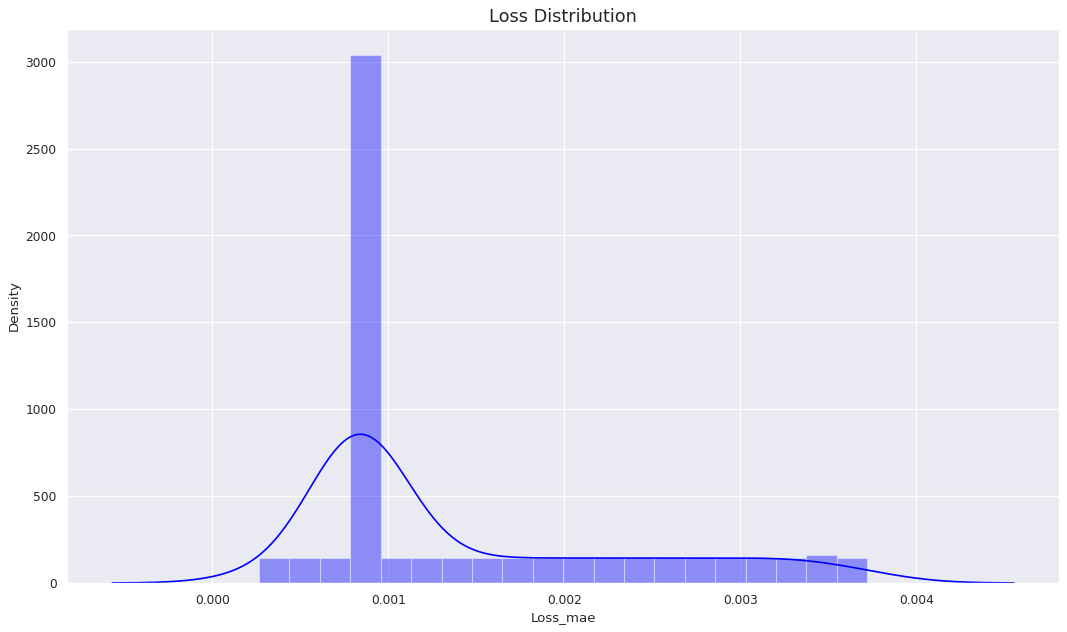

In [35]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');

In [36]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.0045
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Loss_mae,Threshold,Anomaly
0,0.003384,0.0045,False
1,0.000837,0.0045,False
2,0.003037,0.0045,False
3,0.000837,0.0045,False
4,0.002691,0.0045,False


<Axes: >

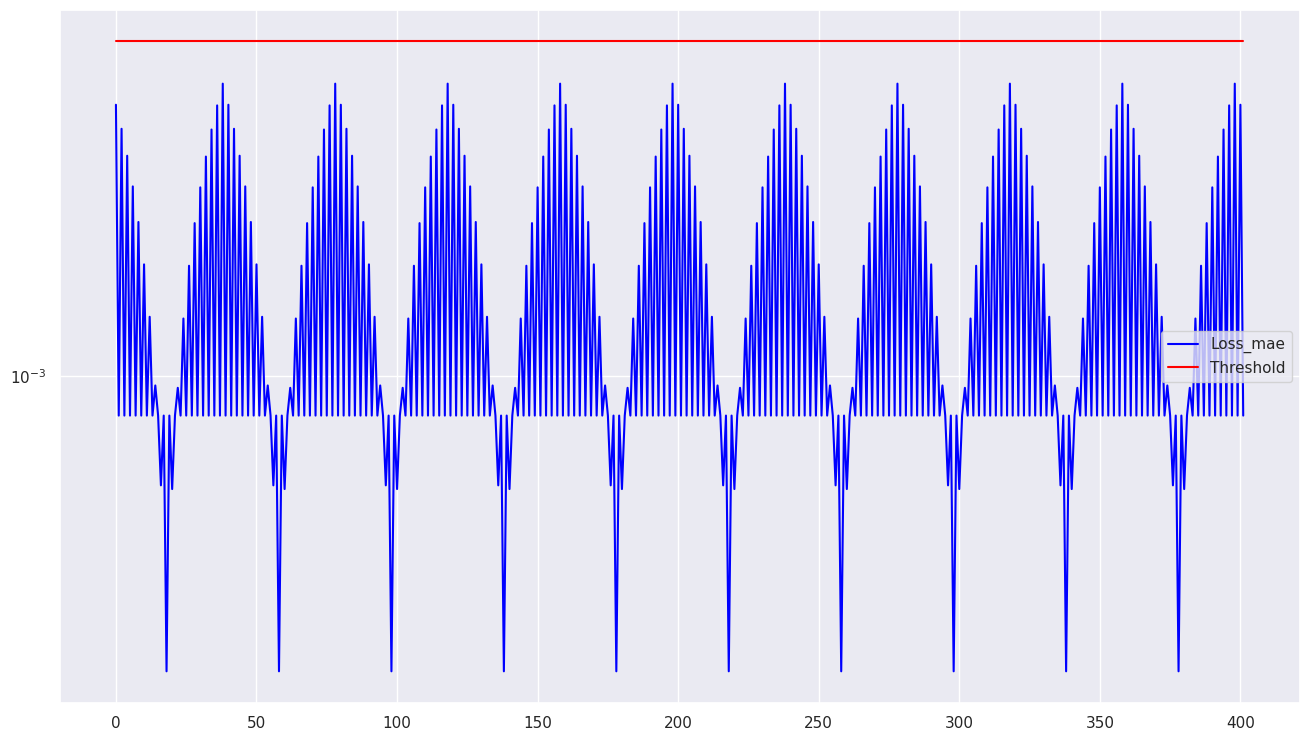

In [37]:
scored.plot(logy=True,  figsize=(16,9), color=['blue','red'])

In [38]:
model.save("master_and_slave.h5")
print("Model saved")

Model saved


In [39]:
def process_file(csv_file):
    test = pd.read_csv(csv_file)

    # Selección de columnas de interés
    test = test[
        [
            'priority','function','subfunction','node_id', # CANID
            'len', # Length del payload
            'd0','d1','d2','d3','d4','d5','d6','d7' # Payload
        ]
    ]
    test = test.apply(lambda x: x.astype(str).map(lambda x: float(int(x, base=16))))
    x = test.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    test = pd.DataFrame(x_scaled)

    X_test = test.values
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # calculate the loss on the test set
    X_pred = model.predict(X_test)
    X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
    X_pred = pd.DataFrame(X_pred, columns=test.columns)
    X_pred.index = test.index

    scored = pd.DataFrame(index=test.index)
    Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
    scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
    scored['Threshold'] = 0.0045
    scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
    #scored.head()

    # plot bearing failure time plot
    scored.plot(logy=True,  figsize=(16,9), color=['blue','red'])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


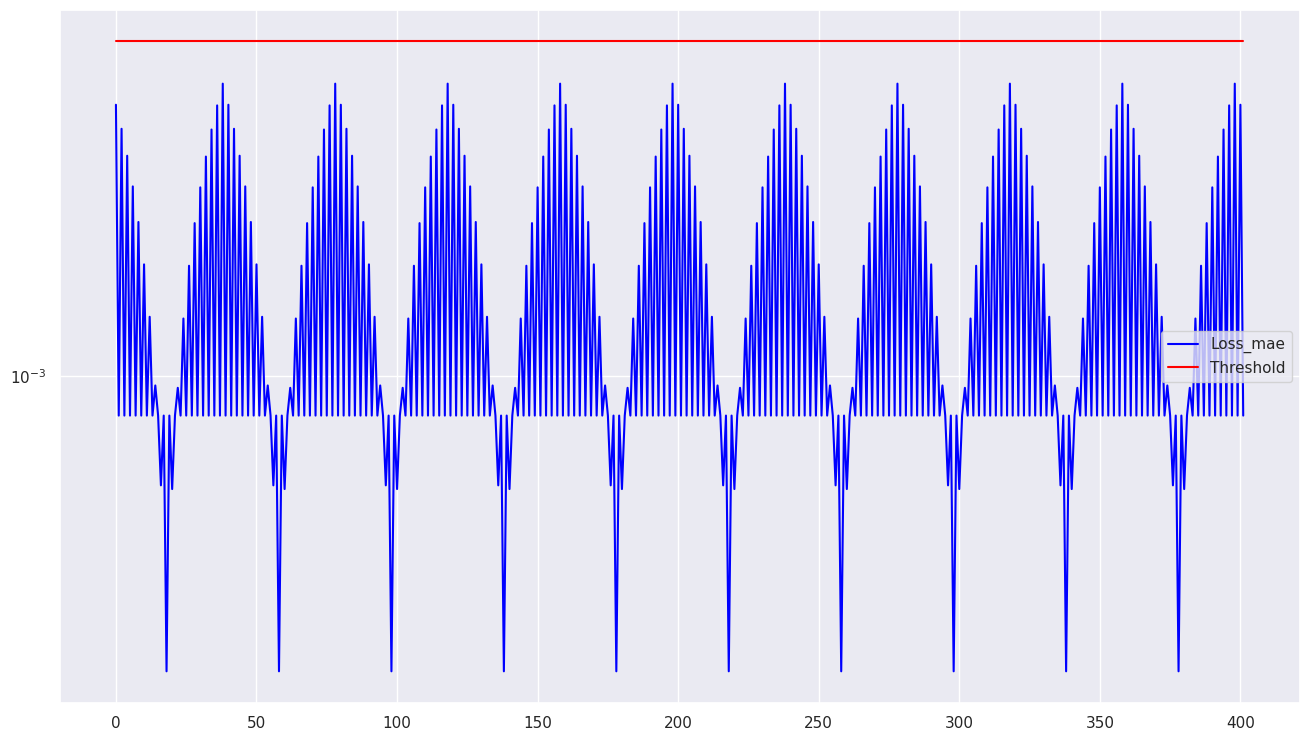

In [41]:
process_file("/content/10_second_master_and_slave.csv")